In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester
from convlstm import ConvLSTM

Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset_type = 'chirps'
param = {'layer_size': 3, 'kernel_size': 5, 'hidden_dim': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[y_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[X_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[X_test] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_test] Shape: torch.Size([10809, 1, 5, 32, 32])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

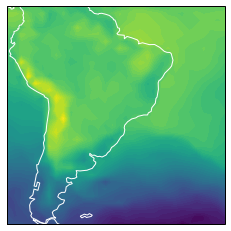

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

Creating the model

In [15]:
class STConvLSTM(nn.Module):
    
    def __init__(self, layer_size, kernel_size, input_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.conv_lstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        
        input_dim=1
        for i in range(layer_size):
            self.conv_lstm_layer.append(ConvLSTM(input_size=input_size, input_dim=input_dim, hidden_dim=hidden_dim,
                                                kernel_size=(kernel_size, kernel_size),
                                                 num_layers=1, batch_first=True, bias=False, return_all_layers=True))
            self.relu_layers.append(nn.ReLU())
            self.bn_layers.append(nn.BatchNorm3d(hidden_dim))
            input_dim = hidden_dim
            
        self.final_conv = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, bn in zip(self.conv_lstm_layer, self.relu_layers, self.bn_layers):
            x, h = convlstm(x)
            x = bn(x[0])
            x = relu(x)
            
        out = self.final_conv(x)
        return out

In [16]:
model = STConvLSTM(layer_size, kernel_size, input_size=(train_data.x.shape[3], train_data.x.shape[4]), hidden_dim=hidden_dim).to(device)
criterion = torch.nn.L1Loss()
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [17]:
model_path = os.path.join('../../../models/CFSR/5_step/ConvLSTM_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, False, model_path, False, 5)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 7.062263
Val Avg. Loss: 2.076614
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.522612
Val Avg. Loss: 2.388411
Train - Epoch 2, Epoch Loss: 1.434039
Val Avg. Loss: 1.643979
=> Saving a new best
Train - Epoch 3, Epoch Loss: 1.396212
Val Avg. Loss: 1.548596
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.367945
Val Avg. Loss: 1.661818
Train - Epoch 5, Epoch Loss: 1.346598
Val Avg. Loss: 1.618357
Train - Epoch 6, Epoch Loss: 1.330019
Val Avg. Loss: 1.645575
Train - Epoch 7, Epoch Loss: 1.316089
Val Avg. Loss: 1.579426
Train - Epoch 8, Epoch Loss: 1.306630
Val Avg. Loss: 1.950359


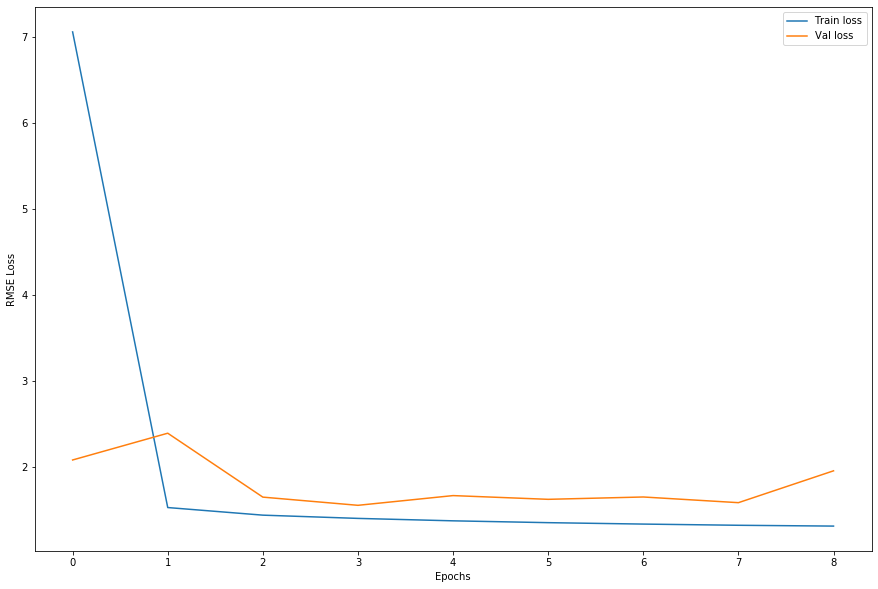

In [19]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [20]:
model, optimizer, epoch, loss = trainer.load_model()
tester = Tester(model, test_loader, criterion, optimizer, device, False, False)
test_loss = tester.test()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S L1Loss: 1.5171


In [ ]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()